# Preprocessing Visium dataset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import skimage.io
import skimage.filters
import skimage.color
import skimage.morphology
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = None

import torch
import numpy as np
import scipy
import torchvision.transforms as transforms

file_1 = "191203_5k_CN021_2_Allen_HE_AM_SNA-Spot000001.jpg"
file_2 = "191206_5K_CN026_1_allen_HE_SN_AM-Spot000001.jpg"
file_3 = "200128_Allen_V19T26_ID098_AM-Spot000001.jpg"
file_4 = "200128_Allen_V4_V19T26_ID098_A-Spot000001.jpg"

In [3]:
def open_and_resize(pilfile, mode: str = 'L', reduction_factor: int =1):
    """ crop_first, resize later.
        box_crop = (left, upper, right, lower)-tuple. """

    pilobject = PIL.Image.open(pilfile).convert(mode)
        
    w_raw, h_raw = pilobject.size

    w_new = int(w_raw/reduction_factor)
    h_new = int(h_raw/reduction_factor)

    # LANCZOS prevent antialiasing when downsampling
    if reduction_factor == 1:
        img_np = np.array(pilobject)
    else:
        pilresize = pilobject.resize((w_new,h_new), resample=PIL.Image.BILINEAR)  
        img_np = np.array(pilresize)
    return img_np

def getLargestCC(mask):
    labels = skimage.measure.label(mask)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC

def find_bbox(mask):
    assert len(mask.shape) == 2
    row = np.sum(mask, axis=-1) > 0
    col = np.sum(mask, axis=-2) > 0
    max_row = max(np.arange(row.shape[0])*row) + 1
    min_row = row.shape[0] - max(np.arange(start=row.shape[0],stop=0, step=-1)*row)
    max_col = max(np.arange(col.shape[0])*col) + 1
    min_col = col.shape[0] - max(np.arange(start=col.shape[0],stop=0, step=-1)*col)
    return (min_row,min_col,max_row,max_col)

def show_video(frames: np.ndarray,
               ref_image: np.ndarray,
               sigma: np.ndarray,
               figsize: tuple = (8, 4),
               interval: int = 50):
    """
    :param video: an ndarray with shape (n_frames, height, width, 3)
    """
    fig, axs = plt.subplots(ncols=2, figsize=figsize)
    ax_image = axs[0]
    ax_video = axs[1]
    
    # image
    ax_image.axis('off')
    ax_image.imshow(ref_image)
    ax_image.set_title("ref image")
    
    ax_video.axis('off')
    ax_video.imshow(frames[0, ...])
    ax_video.set_title("title")
        
    plt.tight_layout()
    plt.close()
    
    def init():
        ax_video.imshow(frames[0, ...])
        ax_video.set_title("title")
        
    def animate(i):
        title = 'corrupted prediction, frame={0:3d}, sigma={1:.3f}'.format(i,sigma[i])
        ax_video.imshow(frames[i, ...])
        ax_video.set_title(title)
        
    anim = animation.FuncAnimation(
        fig, animate, init_func=init, frames=frames.shape[0],
        interval=interval)
    
    return HTML(anim.to_html5_video())

# Use a small thumbnail to estimate the parameters

Open both a RBG and gray_scale image

In [4]:
small_img = open_and_resize(file_1, mode='RGB', reduction_factor=10)
small_img_gray = skimage.color.rgb2gray(small_img)
torch_large_image = transforms.ToTensor()(img).unsqueeze_(0)
print(small_img.shape)

(3174, 3174, 3)


Text(0.5, 1.0, 'GRAYSCALE image, zoom')

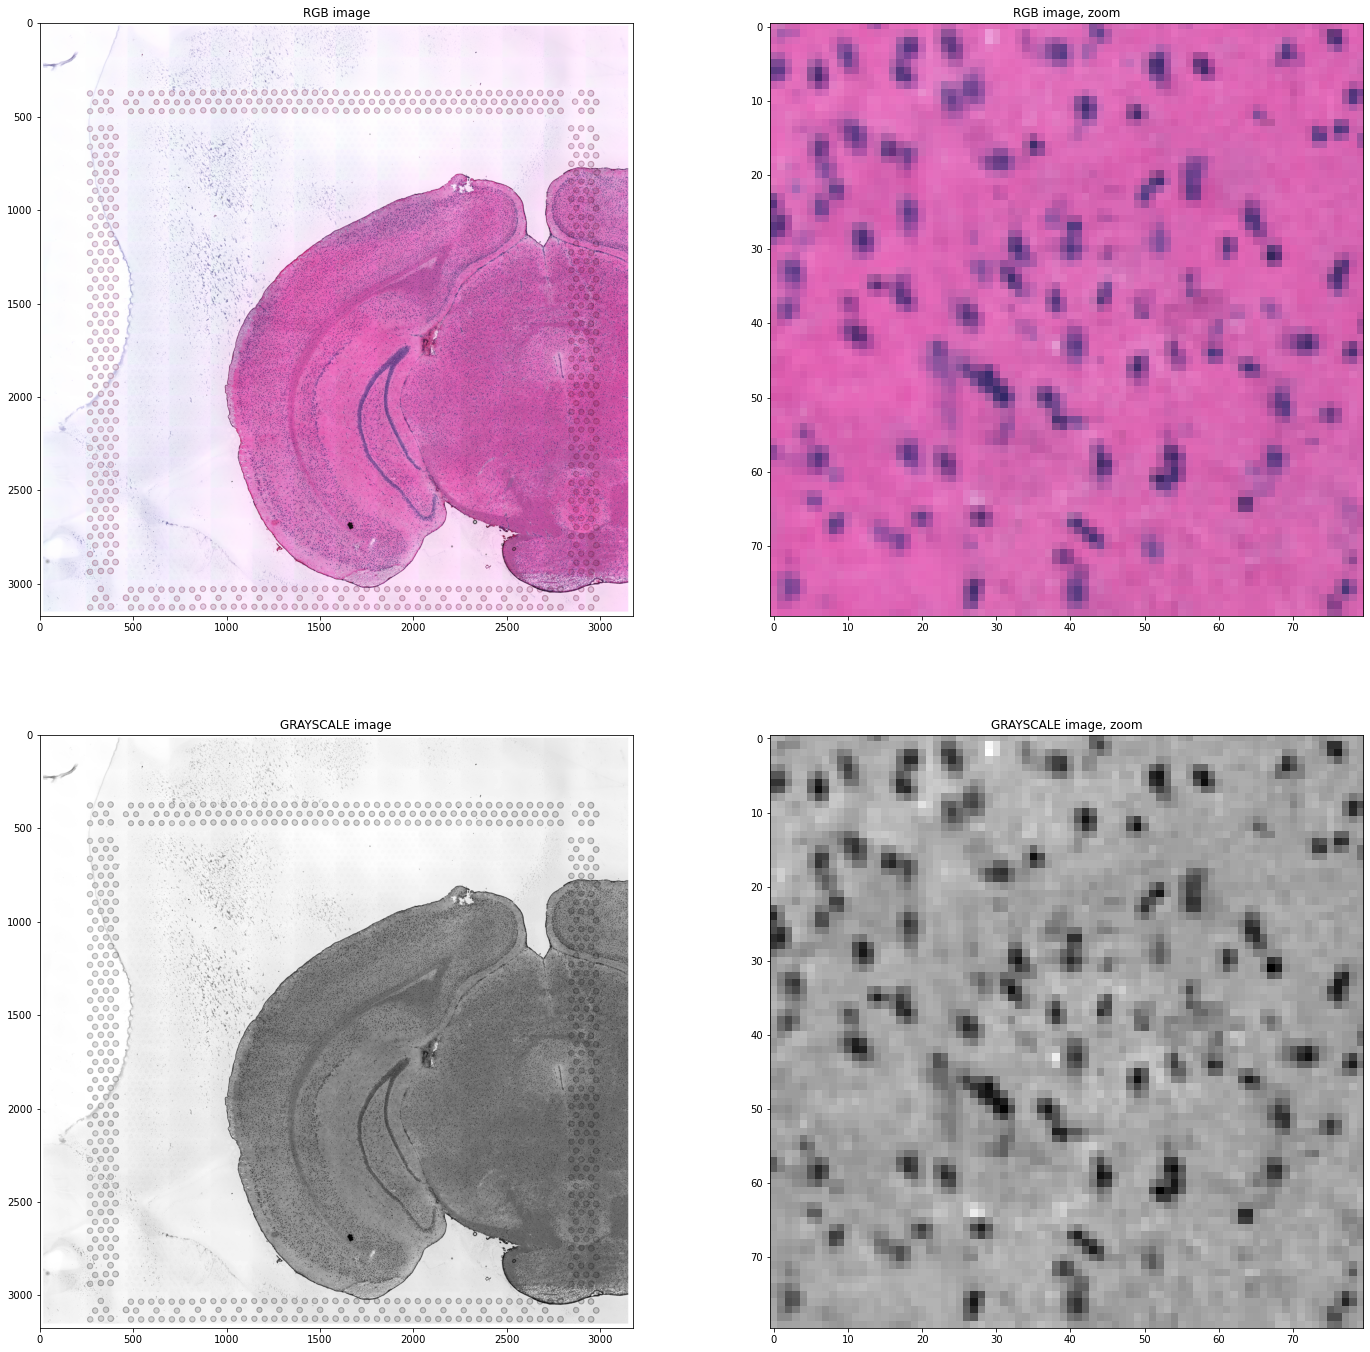

In [5]:
delta=80
iw, ih = 2000, 2000
figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 24))
axes[0,0].imshow(small_img)
axes[0,1].imshow(small_img[iw:iw+delta,ih:ih+delta,:])
axes[1,0].imshow(small_img_gray, cmap='gray')
axes[1,1].imshow(small_img_gray[iw:iw+delta,ih:ih+delta], cmap='gray')
axes[0,0].set_title("RGB image")
axes[0,1].set_title("RGB image, zoom")
axes[1,0].set_title("GRAYSCALE image")
axes[1,1].set_title("GRAYSCALE image, zoom")

Separate out the image, fill the gaps, and select the largest connected components

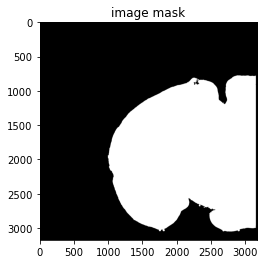

In [9]:
thresh = skimage.filters.threshold_otsu(small_img_gray)
small_mask = getLargestCC(scipy.ndimage.binary_fill_holes(small_img_gray < thresh))

plt.imshow(small_mask, cmap='gray')
_ = plt.title("image mask")

Set background to zero, compute the mean of each channel and check the histogram

In [150]:
mean_each_channel_RGB = np.mean(small_img[small_mask], axis=-2).astype(int)
mean_each_channel_GRAY = np.mean(small_img_gray[small_mask])
print(mean_each_channel_RGB, mean_each_channel_GRAY)

#small_img[~small_mask] = 0.0
#small_img_gray[~small_mask] = 0.0
small_img[~small_mask] = mean_each_channel_RGB
small_img_gray[~small_mask] = mean_each_channel_GRAY

[198 101 173] 0.49936208690412387


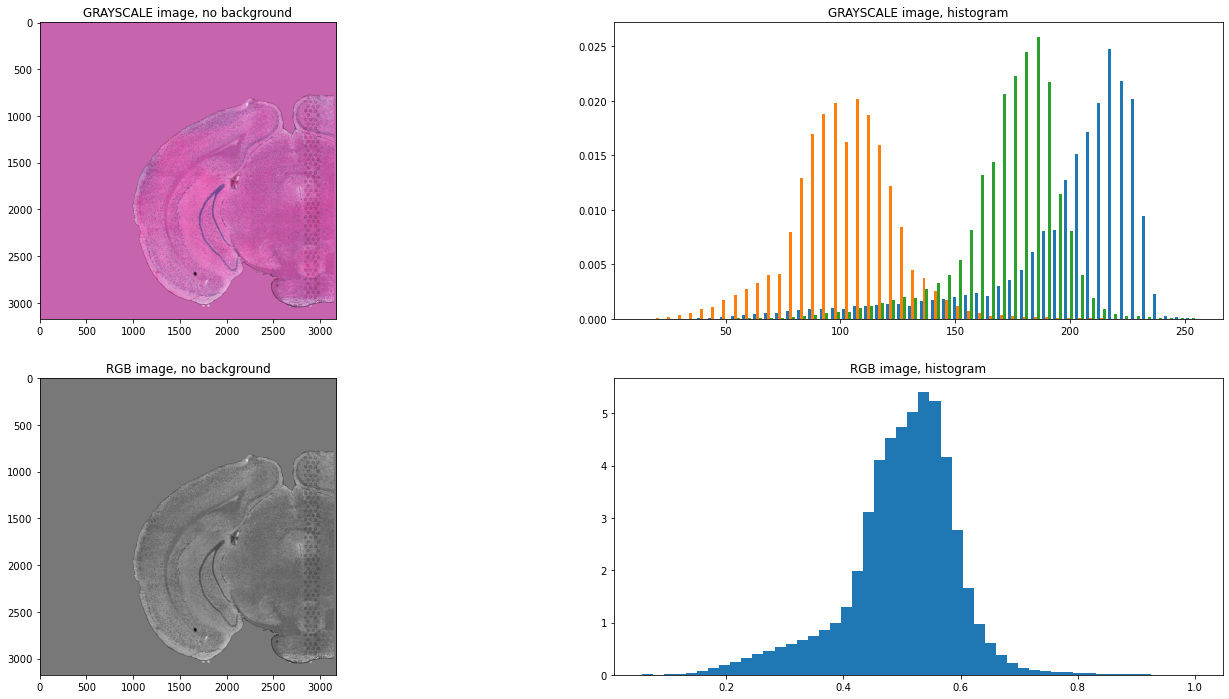

In [151]:
figure, axes = plt.subplots(ncols=2, nrows=2, figsize=(24, 12))

_ = axes[0,0].imshow(small_img)
_ = axes[0,1].hist(small_img[small_mask], bins=50, density=True)
_ = axes[1,0].imshow(small_img_gray, cmap='gray') 
_ = axes[1,1].hist(small_img_gray[small_mask], bins=50, density=True)

_ = axes[0,0].set_title("GRAYSCALE image, no background")
_ = axes[0,1].set_title("GRAYSCALE image, histogram")
_ = axes[1,0].set_title("RGB image, no background")
_ = axes[1,1].set_title("RGB image, histogram")

### Estimate the fraction of pixel belonging to nuclei

In [152]:
#thresh_v2 = skimage.filters.threshold_otsu(small_img_gray[small_mask])
#cells = (small_img_gray < thresh_v2) * small_mask

thresh_v2 = skimage.filters.threshold_local(small_img_gray, block_size=25, method='mean', offset=0, mode='constant', cval=0)
nuclei = (small_img_gray < thresh_v2 - 0.05) * small_mask

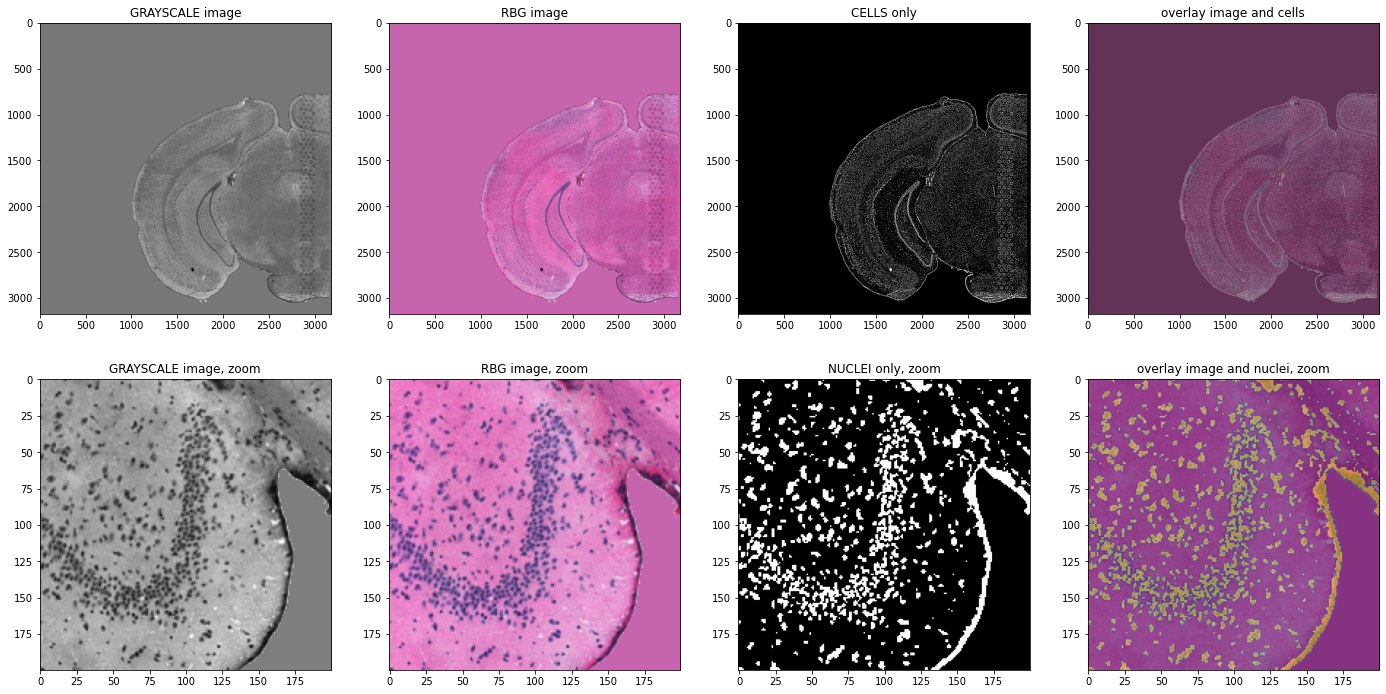

In [153]:
delta = 200
iw, ih = 2500, 2000
figure, axes = plt.subplots(ncols=4, nrows=2, figsize=(24, 12))
gray_img = axes[0,0]
rgb_img = axes[0,1]
instances = axes[0,2]
overlay = axes[0,3]

gray_img_zoom = axes[1,0]
rgb_img_zoom = axes[1,1]
instances_zoom = axes[1,2]
overlay_zoom = axes[1,3]

rgb_img.imshow(small_img)
gray_img.imshow(small_img_gray, cmap='gray')
instances.imshow(nuclei, cmap='gray')
overlay.imshow(small_img)
overlay.imshow(nuclei, alpha=0.5, cmap='gray')

rgb_img_zoom.imshow(small_img[iw:iw+delta,ih:ih+delta,:])
gray_img_zoom.imshow(small_img_gray[iw:iw+delta,ih:ih+delta], cmap='gray')
instances_zoom.imshow(nuclei[iw:iw+delta,ih:ih+delta], cmap='gray')
overlay_zoom.imshow(small_img[iw:iw+delta,ih:ih+delta,:])
overlay_zoom.imshow(nuclei[iw:iw+delta,ih:ih+delta], alpha=0.5)#, cmap='gray')

_ = rgb_img.set_title("RBG image")
_ = rgb_img_zoom.set_title("RBG image, zoom")
_ = gray_img.set_title("GRAYSCALE image")
_ = gray_img_zoom.set_title("GRAYSCALE image, zoom")
_ = instances.set_title("CELLS only")
_ = instances_zoom.set_title("NUCLEI only, zoom")
_ = overlay.set_title("overlay image and cells")
_ = overlay_zoom.set_title("overlay image and nuclei, zoom")

### The estimated fraction of fg_pixel is:

In [154]:
print("np.sum(nuclei) ------>",np.sum(nuclei))
print("np.sum(small_mask) ->",np.sum(small_mask))
print("fraction cell_pixel -->",float(np.sum(nuclei))/np.sum(small_mask))

np.sum(nuclei) ------> 611409
np.sum(small_mask) -> 3890465
fraction cell_pixel --> 0.15715576415672677


## Chose sigma for mean square error

Deteriorate the image by applying gaussian filter with increasing spatial support

In [155]:
gaussian_filter = np.arange(0,10)  # sigma=0 has no smoothing, i.e. original image
predictions = np.zeros([gaussian_filter.shape[0]]+list(small_img.shape))
for n,s in enumerate(gaussian_filter):
    tmp = skimage.filters.gaussian(small_img, sigma=s, multichannel=True)
    predictions[n] = tmp

$ MSE = \frac{1}{W H C}\sum_{x,y,c} \left( \frac{\text{prediction} - \text{reference}}{\sigma}\right)^2 = 1$ 
implies that
$\sigma = \sqrt{ \frac{1}{W H C} \sum_{x,y,c} \left(\text{prediction} - \text{reference}\right)^2} $

In [156]:
diff = (predictions - predictions[0])*small_mask[...,None]
mean_error = np.sum(diff**2, axis=(-1,-2,-3)) / (small_img.shape[-1]*np.sum(small_mask)) # sum 
sigma = np.sqrt(mean_error)

In [157]:
show_video(frames=predictions[:,iw:iw+delta,ih:ih+delta,:], 
           ref_image=small_img[iw:iw+delta,ih:ih+delta,:],
           sigma=sigma,
           interval=500)

# Get the large images

In [134]:
import torchvision.transforms as transforms

large_img_np = open_and_resize(file_1, mode='RGB', reduction_factor=1)
large_mask_np = skimage.transform.resize(small_mask, 
                                         output_shape=large_img_np.shape[-3:-1], 
                                         order=0).astype(bool)

In [135]:
large_img_np[~large_mask_np] = mean_each_channel_RGB

In [139]:
print(find_bbox(small_mask))

(776, 987, 3051, 3143)


crop the image to the region of interest

In [140]:
min_row,min_col,max_row,max_col = find_bbox(large_mask_np)
print(min_row,min_col,max_row,max_col)
large_img_cropped = large_img_np[min_row:max_row,min_col:max_col]
large_mask_cropped = large_mask_np[min_row:max_row,min_col:max_col]

7761 9871 30514 31434


In [141]:
large_mask_cropped.shape

(22753, 21563)

From this image I see that cells have a size of about 15-45 pixels

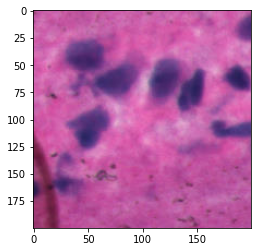

In [144]:
plt.imshow(large_img_cropped[20000:20200,20000:20200,:])

# Transform to torch and save

In [158]:
print(large_img_cropped.shape, large_img_cropped.dtype)
print(large_mask_cropped.shape, large_mask_cropped.dtype)

torch_img = transforms.ToTensor()(large_img_cropped)
torch_mask = transforms.ToTensor()(large_mask_cropped)

print(torch_img.shape, torch_img.dtype)
print(torch_mask.shape, torch_mask.dtype)

(22753, 21563, 3) uint8
(22753, 21563) bool
torch.Size([3, 22753, 21563]) torch.float32
torch.Size([1, 22753, 21563]) torch.bool


In [159]:
f = "preprocessed_"+file_1
torch.save((torch_img,torch_mask), f)

# Conclusion 

For this image the fraction of pixel belonging to the foreground is 15%
The value of sigma which given a reasonable reconstruction is 0.05
Next we prepare the image into a torch tensor and save on file